In [1]:
__author__      = "Tijs Alleman"
__copyright__   = "Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved."

############################
## Load required packages ##
############################

import os
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models.utils import initialize_COVID19_SEIQRD_stratified_vacc, initialize_COVID19_SEIQRD_rescaling_vacc
from covid19model.data import sciensano
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.models.utils import output_to_visuals
from covid19model.models.utils import load_samples_dict

In [15]:
#####################
## Input arguments ##
#####################

# Simulation enddate
end_sim = '2022-03-01'
# Number of age groups used in the model
age_stratification_size=10
# Number of samples to be drawn from the posterior distributions
n = 5
# Number of Negative Binomial draws put on every model prediction
k = 100
# Confidence level
conf_int = 0.05
# Filenames of the samples dictionaries
samples_dict_names = ['BE_BASE_rescaling_SAMPLES_2022-05-11.json', 'BE_BASE_stratified_SAMPLES_2022-05-11.json']
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/national/'

## Run both models on rescaling model parameters

In [6]:
#############################
## Load samples dictionary ##
#############################

start_calibration_list=[]
end_calibration_list=[]
dispersion_list=[]
samples_dict_list=[]
for name in samples_dict_names:
    samples_dict = load_samples_dict(samples_path+str(name), age_stratification_size=age_stratification_size)
    samples_dict_list.append(samples_dict)
    # Start of calibration warmup and beta
    start_calibration_list.append(samples_dict['start_calibration'])
    # Last datapoint used to calibrate warmup and beta
    end_calibration_list.append(samples_dict['end_calibration'])
    # Overdispersion data
    dispersion_list.append(float(samples_dict['dispersion']))

##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()

##########################
## Initialize the models ##
##########################

model_rescaling, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_rescaling_vacc(age_stratification_size=age_stratification_size, start_date=start_calibration_list[0], update_data=False)
model_stratified, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_stratified_vacc(age_stratification_size=age_stratification_size, start_date=start_calibration_list[1], update_data=False)

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_national as draw_fcn

In [16]:
#########################
## Perform simulations ##
#########################

out_rescaling = model_rescaling.sim(end_sim,start_date=start_calibration_list[0],N=n,draw_fcn=draw_fcn,samples=samples_dict_list[0], verbose=True)
out_stratified = model_stratified.sim(end_sim,start_date=start_calibration_list[0],N=n,draw_fcn=draw_fcn,samples=samples_dict_list[1], verbose=True)

###################
## Format output ##
###################

df_2plot_rescaling = output_to_visuals(out_rescaling, ['H_in'], alpha=dispersion_list[0], n_draws_per_sample=k, UL=1-conf_int*0.5, LL=conf_int*0.5)
df_2plot_stratified = output_to_visuals(out_stratified, ['H_in'], alpha=dispersion_list[1], n_draws_per_sample=k, UL=1-conf_int*0.5, LL=conf_int*0.5)

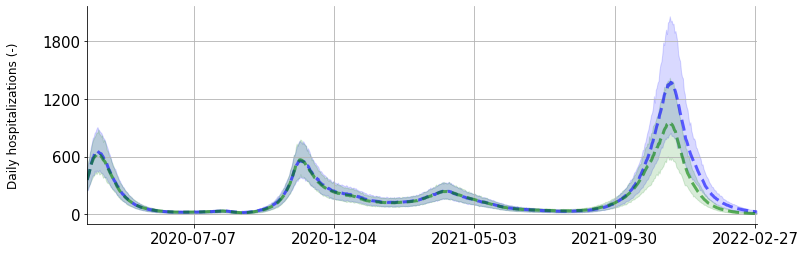

In [18]:
start_calibration = '2020-03-15'
end_calibration = '2021-10-07'

########################################
## Visualize result: rescaling params ##
########################################

fig,ax = plt.subplots(figsize=(12,4))

# Rescaling model
ax.plot(df_2plot_rescaling['H_in','mean'],'--', color='blue', alpha=0.6)
ax.fill_between(df_2plot_rescaling['H_in','lower'].index, df_2plot_rescaling['H_in','lower'], df_2plot_rescaling['H_in','upper'],alpha=0.15, color = 'blue')
#ax.scatter(df_hosp[start_calibration:end_calibration].index,df_hosp['H_in'][start_calibration:end_calibration], color='red', alpha=0.2, linestyle='None', facecolors='none', s=60, linewidth=2)
#ax.scatter(df_hosp[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_hosp['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax = _apply_tick_locator(ax)
ax.set_xlim(start_calibration,end_sim)
ax.set_ylabel('Daily hospitalizations (-)', fontsize=12)
ax.get_yaxis().set_label_coords(-0.1,0.5)

# Rescaling model
ax.plot(df_2plot_stratified['H_in','mean'],'--', color='green', alpha=0.6)
ax.fill_between(df_2plot_stratified['H_in','lower'].index, df_2plot_stratified['H_in','lower'], df_2plot_stratified['H_in','upper'],alpha=0.15, color = 'green')

ax = _apply_tick_locator(ax)
ax.set_xlim(start_calibration,end_sim)
ax.set_ylabel('Daily hospitalizations (-)', fontsize=12)
ax.get_yaxis().set_label_coords(-0.1,0.5)
